### 【問題1】各種手法の実行 

Kerasには4種類のReccurentレイヤーが用意されています。SimpleRNN以外はゲート付きリカレントニューラルネットワークです。


- SimpleRNN
- GRU
- LSTM
- ConvLSTM2D

これらを実行してください。この中でSimpleRNN、GRU、LSTMは同様のタスクに用いることができるため、精度の比較も行なってください。

参考kaggleコンペティション：[Real or Not? NLP with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started/data)

参考kaggleノートブック：[RNN学習用　NO.1](https://www.kaggle.com/kojiiwase/rnn-no-1)

In [1]:
import numpy as np
import pandas as pd

In [39]:
import keras as keras
from keras.models import Sequential, load_model
from keras.layers import LSTM, GRU,SimpleRNN
from keras.layers import Dense, Embedding, Bidirectional, Dropout, Flatten
from keras.optimizers import Adam, SGD
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
early_stop=keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')

In [3]:
keras.__version__

'2.0.2'

- Dataset Load

In [5]:
train = pd.read_csv('./nlp-getting-started/train.csv')
test = pd.read_csv('./nlp-getting-started/test.csv')

In [6]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
print('Training Dataset contain {} samples'.format(train.shape[0]))
print('Testing Dataset contain {} samples'.format(test.shape[0]))

Training Dataset contain 7613 samples
Testing Dataset contain 3263 samples


In [9]:
train = train.drop(['id', 'keyword', 'location'], axis=1)
test = test.drop(['id', 'keyword', 'location'], axis=1)

In [11]:
y_train =  train['target'].values
X_train = train.drop(['target'], axis=1).values.reshape(len(train),)
X_test = test['text'].values.reshape(len(test),)

In [12]:
print(X_test)

['Just happened a terrible car crash'
 'Heard about #earthquake is different cities, stay safe everyone.'
 'there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all'
 ... 'Green Line derailment in Chicago http://t.co/UtbXLcBIuY'
 'MEG issues Hazardous Weather Outlook (HWO) http://t.co/3X6RBQJHn3'
 '#CityofCalgary has activated its Municipal Emergency Plan. #yycstorm']


In [13]:
print(y_train)
print(X_train)

[1 1 1 ... 1 1 1]
['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'
 'Forest fire near La Ronge Sask. Canada'
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"
 ... 'M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ'
 'Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.'
 'The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d']


- Preprocessing

In [14]:
total_tweets = np.concatenate((X_train, X_test))
print('Total tweets : ', len(total_tweets))

Total tweets :  10876


In [15]:
total_tweets

array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       ..., 'Green Line derailment in Chicago http://t.co/UtbXLcBIuY',
       'MEG issues Hazardous Weather Outlook (HWO) http://t.co/3X6RBQJHn3',
       '#CityofCalgary has activated its Municipal Emergency Plan. #yycstorm'],
      dtype=object)

In [16]:
# 単語の文字列のindexを構築
tokenizer = Tokenizer()
tokenizer.fit_on_texts(total_tweets)

# Vocbvulary Size
#　trian、testのツイートの総単語数（単語の次元数）を取得
vocab_size = len(tokenizer.word_index) + 1
print('Size of Vocabulary : ', vocab_size)

Size of Vocabulary :  29320


In [17]:
# Maximum length for padding sequence
maxlen = max(len(x.split()) for x in total_tweets)
print('Maximum length of tweet : ', maxlen)

Maximum length of tweet :  31


In [18]:
# 文字列を整数のインデックスのリストに変換
X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)

print('Text before tokenized')
print(X_train[0])
print('\nText after tokenized')
print(X_train_token[0])

Text before tokenized
Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all

Text after tokenized
[114, 5944, 24, 4, 850, 8, 21, 253, 151, 1820, 3841, 88, 41]


In [19]:
# 要素の合わない配列に対して、0 で埋めるなどして配列のサイズを一致させる。
# 一番長いtweetの単語数に合わせる paddding='post’ にすると後ろに0が追加される
X_train_pad = pad_sequences(X_train_token, maxlen=maxlen, padding='post')
X_test_pad = pad_sequences(X_test_token, maxlen=maxlen, padding='post')

print('Tokenized text before padding')
print(X_train_token[0])
print('\nTokenized text after padding')
print(X_train_pad[0])


Tokenized text before padding
[114, 5944, 24, 4, 850, 8, 21, 253, 151, 1820, 3841, 88, 41]

Tokenized text after padding
[ 114 5944   24    4  850    8   21  253  151 1820 3841   88   41    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]


- モデルを作成

__SimpleRNN__

In [20]:
embed_units=100
hidden_units=128

model=Sequential()
model.add(Embedding(vocab_size, embed_units, input_length = maxlen))
model.add(SimpleRNN(hidden_units))
model.add(Dropout(0.2))
#model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.summary()




Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 31, 100)           2932000   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 128)               29312     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)  

In [21]:
learning_rate = 0.0001

model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [22]:
batch_size_1= 150
batch_size_2= 300
batch_size_3= 700
num_itr = 5
es_cb=keras.callbacks.EarlyStopping( patience=0, verbose=0)
model_history = model.fit(X_train_pad, y_train, 
                          batch_size=batch_size_1, 
                          epochs=num_itr, 
                          validation_split=0.3,
                          callbacks=[es_cb])


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 5329 samples, validate on 2284 samples
Epoch 1/5
5329/5329 [==============================] - 2s - loss: 0.6075 - acc: 0.6829 - val_loss: 0.5831 - val_acc: 0.7158
Epoch 2/5
5329/5329 [==============================] - 2s - loss: 0.3258 - acc: 0.8775 - val_loss: 0.6125 - val_acc: 0.7220


__GRU__

In [27]:
model_LS = Sequential()
model_LS.add(Embedding(vocab_size, embed_units, input_length = maxlen))
model_LS.add(GRU(hidden_units))
model_LS.add(Dropout(0.2))
#model.add(Flatten())
model_LS.add(Dense(256, activation='relu'))
model_LS.add(Dropout(0.2))
model_LS.add(Dense(1, activation='sigmoid'))

model_LS.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 31, 100)           2932000   
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               87936     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 3,053,217.0
Trainable params: 3,053,217.0
Non-trainable params: 0.0
____________________________________________________________

In [28]:
learning_rate = 0.0001

model_LS.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [29]:
model_LS_history = model_LS.fit(X_train_pad, y_train, 
                          batch_size=batch_size_1, 
                          epochs=num_itr, 
                          validation_split=0.3,
                          callbacks=[es_cb])

Train on 5329 samples, validate on 2284 samples
Epoch 1/5
5329/5329 [==============================] - 4s - loss: 0.6828 - acc: 0.5750 - val_loss: 0.6869 - val_acc: 0.5582
Epoch 2/5
5329/5329 [==============================] - 4s - loss: 0.6820 - acc: 0.5755 - val_loss: 0.6869 - val_acc: 0.5582


__LSTM__

In [23]:
model_LS = Sequential()
model_LS.add(Embedding(vocab_size, embed_units, input_length = maxlen))
model_LS.add(LSTM(hidden_units))
model_LS.add(Dropout(0.2))
#model.add(Flatten())
model_LS.add(Dense(256, activation='relu'))
model_LS.add(Dropout(0.2))
model_LS.add(Dense(1, activation='sigmoid'))

model_LS.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 31, 100)           2932000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 3,082,529.0
Trainable params: 3,082,529.0
Non-trainable params: 0.0
____________________________________________________________

In [24]:
learning_rate = 0.0001

model_LS.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [26]:
model_LS_history = model_LS.fit(X_train_pad, y_train, 
                          batch_size=batch_size_1, 
                          epochs=num_itr, 
                          validation_split=0.3,
                          callbacks=[es_cb])

Train on 5329 samples, validate on 2284 samples
Epoch 1/5
5329/5329 [==============================] - 4s - loss: 0.3264 - acc: 0.8754 - val_loss: 0.5193 - val_acc: 0.7627
Epoch 2/5
5329/5329 [==============================] - 4s - loss: 0.1422 - acc: 0.9514 - val_loss: 0.5670 - val_acc: 0.7675


- SimpleRNN、GRU及びLSTMでは、LSTMの精度が最も高い。

__ConvLSTM2D__

参考kaggleノートブック：[ConvLSTM: Convolutional LSTM Network Tutorial](https://www.kaggle.com/kcostya/convlstm-convolutional-lstm-network-tutorial)

In [40]:
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
import numpy as np
import pylab as plt

In [41]:
seq = Sequential()

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   input_shape=(None, 40, 40, 1),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
               activation='sigmoid',
               padding='same', data_format='channels_last'))
seq.compile(loss='binary_crossentropy', optimizer='adadelta')

In [42]:
seq.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_7 (ConvLSTM2D)  (None, None, 40, 40, 40)  59200     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 40, 40, 40)  160       
_________________________________________________________________
conv_lst_m2d_8 (ConvLSTM2D)  (None, None, 40, 40, 40)  115360    
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 40, 40, 40)  160       
_________________________________________________________________
conv_lst_m2d_9 (ConvLSTM2D)  (None, None, 40, 40, 40)  115360    
_________________________________________________________________
batch_normalization_3 (Batch (None, None, 40, 40, 40)  160       
_________________________________________________________________
conv_lst_m2d_10 (ConvLSTM2D) (None, None, 40, 40, 40)  115360    
__________

In [43]:
def generate_movies(n_samples=1200, n_frames=15):
    row = 80
    col = 80
    noisy_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float)
    shifted_movies = np.zeros((n_samples, n_frames, row, col, 1),
                              dtype=np.float)

    for i in range(n_samples):
        # Add 3 to 7 moving squares
        n = np.random.randint(3, 8)

        for j in range(n):
            # Initial position
            xstart = np.random.randint(20, 60)
            ystart = np.random.randint(20, 60)
            # Direction of motion
            directionx = np.random.randint(0, 3) - 1
            directiony = np.random.randint(0, 3) - 1

            # Size of the square
            w = np.random.randint(2, 4)

            for t in range(n_frames):
                x_shift = xstart + directionx * t
                y_shift = ystart + directiony * t
                noisy_movies[i, t, x_shift - w: x_shift + w,
                             y_shift - w: y_shift + w, 0] += 1

                # Make it more robust by adding noise.
                # The idea is that if during inference,
                # the value of the pixel is not exactly one,
                # we need to train the network to be robust and still
                # consider it as a pixel belonging to a square.
                if np.random.randint(0, 2):
                    noise_f = (-1)**np.random.randint(0, 2)
                    noisy_movies[i, t,
                                 x_shift - w - 1: x_shift + w + 1,
                                 y_shift - w - 1: y_shift + w + 1,
                                 0] += noise_f * 0.1

                # Shift the ground truth by 1
                x_shift = xstart + directionx * (t + 1)
                y_shift = ystart + directiony * (t + 1)
                shifted_movies[i, t, x_shift - w: x_shift + w,
                               y_shift - w: y_shift + w, 0] += 1

    # Cut to a 40x40 window
    noisy_movies = noisy_movies[::, ::, 20:60, 20:60, ::]
    shifted_movies = shifted_movies[::, ::, 20:60, 20:60, ::]
    noisy_movies[noisy_movies >= 1] = 1
    shifted_movies[shifted_movies >= 1] = 1
    return noisy_movies, shifted_movies

In [44]:
noisy_movies, shifted_movies = generate_movies(n_samples=1200)

In [45]:
noisy_movies.shape, shifted_movies.shape

((1200, 15, 40, 40, 1), (1200, 15, 40, 40, 1))

In [47]:
%%time
seq.fit(noisy_movies[:1000], shifted_movies[:1000], batch_size=10,
        epochs=1, validation_split=0.05)

Train on 950 samples, validate on 50 samples
Epoch 1/1
950/950 [==============================] - 681s - loss: 0.2400 - val_loss: 0.6633
CPU times: user 43min 16s, sys: 17min 36s, total: 1h 52s
Wall time: 11min 21s


In [48]:
which = 1004
track = noisy_movies[which][:7, ::, ::, ::]

In [49]:
track.shape, track[np.newaxis, ::, ::, ::, ::].shape

((7, 40, 40, 1), (1, 7, 40, 40, 1))

In [50]:
for j in range(16):
    new_pos = seq.predict(track[np.newaxis, ::, ::, ::, ::]) # (1, 7, 40, 40, 1)
    new = new_pos[::, -1, ::, ::, ::] # (1, 40, 40, 1)
    track = np.concatenate((track, new), axis=0) # adds +1 to the first dimension in each loop cycle

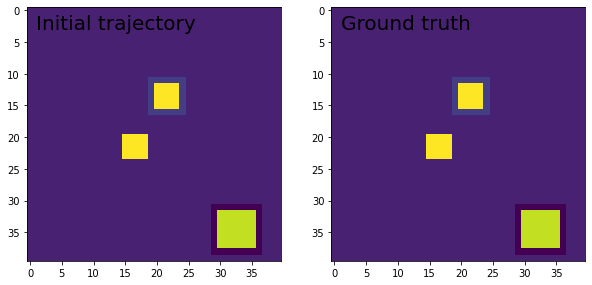

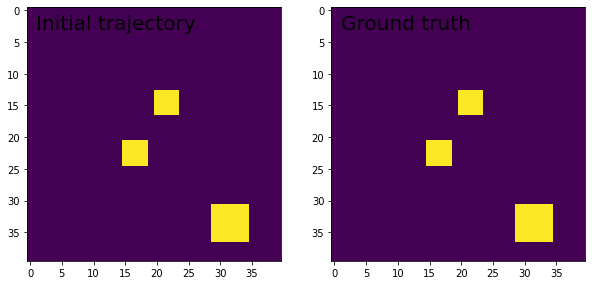

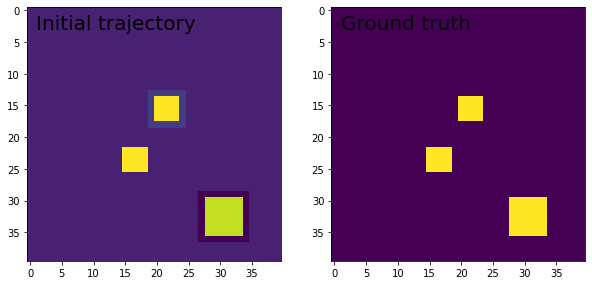

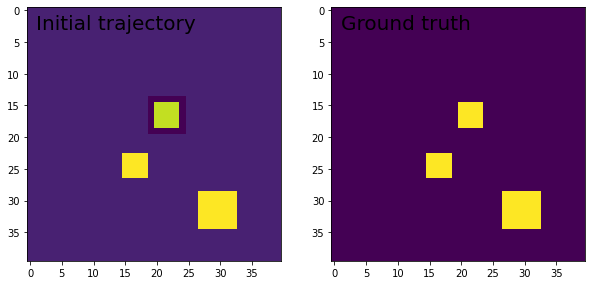

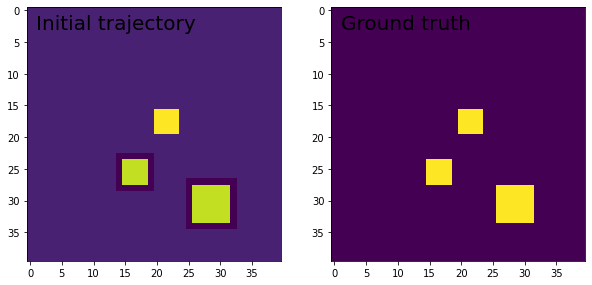

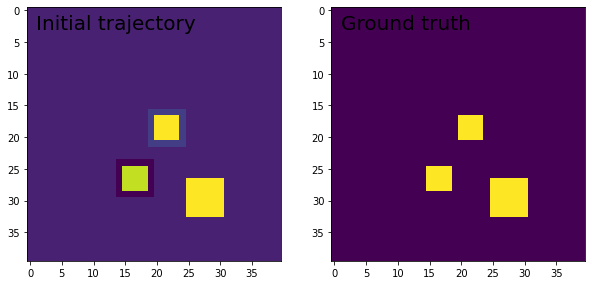

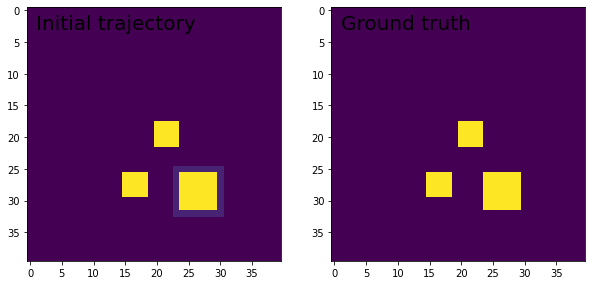

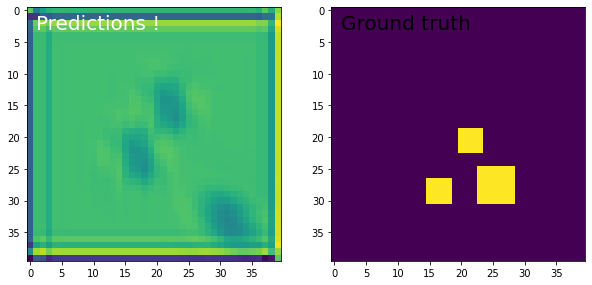

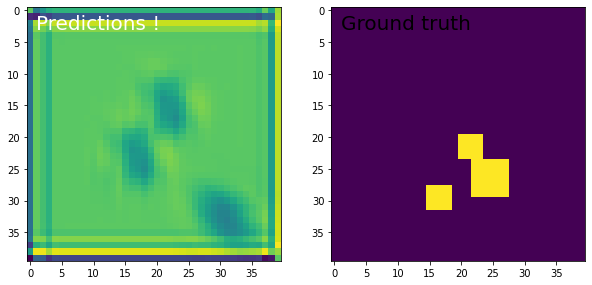

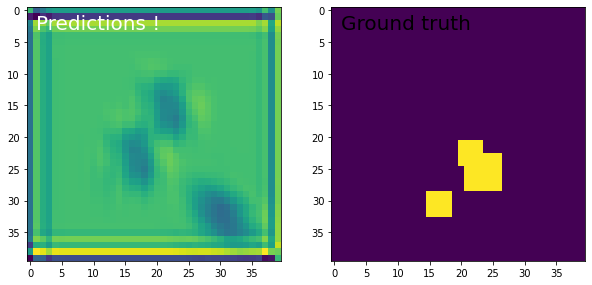

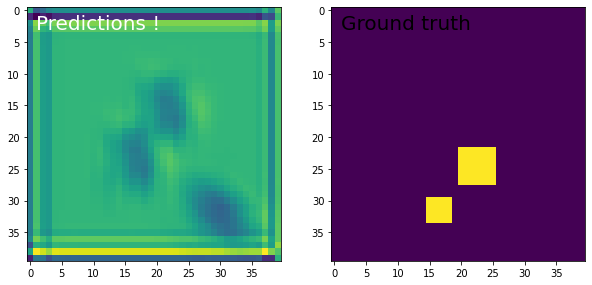

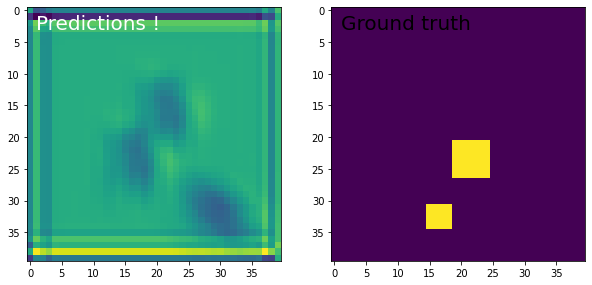

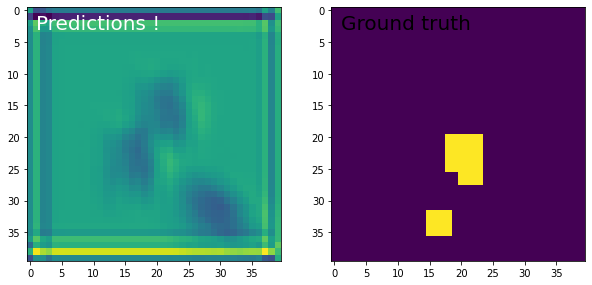

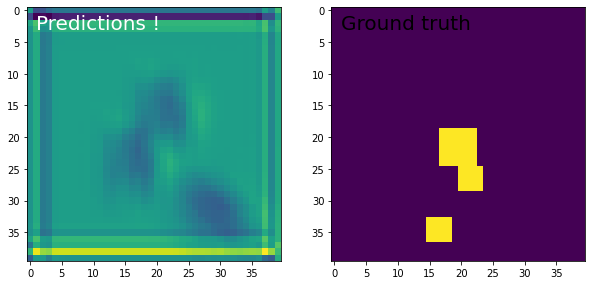

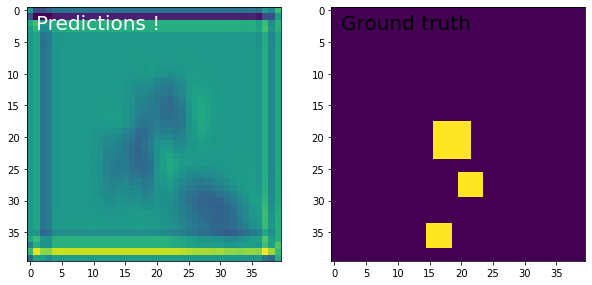

In [51]:
track2 = noisy_movies[which][::, ::, ::, ::]

for i in range(15):
    fig = plt.figure(figsize=(10, 5))

    ax = fig.add_subplot(121)

    if i >= 7:
        ax.text(1, 3, 'Predictions !', fontsize=20, color='w')
    else:
        ax.text(1, 3, 'Initial trajectory', fontsize=20)

    toplot = track[i, ::, ::, 0]

    plt.imshow(toplot)
    ax = fig.add_subplot(122)
    plt.text(1, 3, 'Ground truth', fontsize=20)

    toplot = track2[i, ::, ::, 0]
    if i >= 2:
        toplot = shifted_movies[which][i - 1, ::, ::, 0]

    plt.imshow(toplot)
    #plt.savefig('%i_animate.png' % (i + 1))

### 【問題2】（アドバンス課題）複数のデータセット間での比較 

他のデータセットでも実験を行なってください。

回答無し

### 【問題3】他のクラスの説明 

ドキュメントには他にも関連するクラスが記載されています。それらがどういうものなのかを説明してください。この中には実際に扱うことは少ないクラスも含まれています。

参考図書：　『ゼロから作る Deep Learning ❷』(O'Reilly Japan, 2018)

- __RNN__

    Recurrentレイヤーに対する基底クラス．
    
    
- __SimpleRNNCell__

    SimpleRNNのCellクラス．
    
    SimpleRNNCell で単一のサンプルに対する操作（セル）を定義し、それを基底クラスのRNN() で囲むことによってバッチを処理するレイヤーを定義する事ができる。
    SimpleRNNCell に相当するサンプル単位の処理を自分で定義してRNN()で囲むことにより、好きな構造のRNNを定義できる。


- __GRUCell__

    GRUレイヤーのためのCellクラス.
    
    LSTM同様にゲート付きRNNである。GRUは、LSTMのゲートを使用するというコンセプトはそのままで、パラメータを削減し、計算時間を短縮している。
    LSTMが隠れ状態と記憶セルの2つのラインを使用するのに対して、GRUは隠れ状態だけを使用する。    


- __LSTMCell__

    LSTMレイヤーのためのcellクラス．
    
    LSTMはセル状態と呼ばれる長期記憶ユニットと、隠れ状態と呼ばれる短期記憶ユニットという部分を持つゲート付きRNNである。    
    LSTMの重要な点は、ゲートを使用し、学習時における勾配がスムーズに流れるため、勾配消失を緩和できる点にある。


- __StackedRNNCells__

    RNN cellのスタックの振る舞いを単一のcellのようにするためのラッパー．

    効率的なstacked RNNを実装するために使われる．

    引数

    cells: RNN cellインスタンスのリスト．


- __CuDNNGRU__

    CuDNNを利用した高速なGRU実装．

    TensorFlowバックエンドでGPU上でのみ動作する．


- __CuDNNLSTM__

    CuDNNを利用した高速なLSTM実装．

    TensorFlowバックエンドでGPU上でのみ動作する．

